# Reviewing cardiac measurements
Assess the range of respiratory behaviour caught in individual recordings and evaluate strategies for normalising measurements to be comparable between recordings and participants. 

    1. Review IBI from one participant over: whole concert, whole recording, whole week of recordings.
    2. Considering rate and regularity: how clearly is this extractable? 
    3. Develope compensation strategy normalise values between people and recordings

In [1]:
import sys
import os
import time
import datetime as dt
import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json 
from scipy.signal import butter, filtfilt, argrelextrema
from scipy import interpolate
from scipy.interpolate import interp1d

import activityanalysis_test as act
import respy_test as respy

In [2]:
%load_ext autoreload
%autoreload 1
%aimport eq
%aimport qex
%aimport al
%aimport respy

In [3]:
%reload_ext autoreload

# Load data

In [4]:
Piece_timings = pd.read_csv('./Timing/Concerttimes_Seconds.csv')
PartDets = pd.read_csv('../Data/Participant_Metadata_stage.csv',index_col=0)
player_order = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC703','PC701','PC702','PC708','PC707','PC706']
print(len(player_order))
Dets=PartDets.loc[player_order,['Section', 'Instrument', 'Stage_X', 'Stage_Y']].copy()

57


In [5]:
PartDets.loc[player_order,:]

Section  Instrument  Stage_X  Stage_Y  Con1  Con2  Con3  Con4  Con5  \
PartID                                                                       
VN102      VN1  1st Violin      736      764   1.0   1.0   1.0   1.0   1.0   
VN107      VN1  1st Violin      450      698   1.0   1.0   1.0   1.0   1.0   
VN106      VN1  1st Violin      560      658   1.0   1.0   1.0   1.0   1.0   
VN108      VN1  1st Violin      468      642   1.0   1.0   1.0   1.0   1.0   
VN101      VN1  1st Violin      764      714   1.0   1.0   1.0   1.0   1.0   
VN105      VN1  1st Violin      544      710   1.0   1.0   1.0   1.0   1.0   
VN103      VN1  1st Violin      642      720   1.0   1.0   1.0   1.0   1.0   
VN104      VN1  1st Violin      662      672   1.0   1.0   0.0   1.0   1.0   
VN205      VN2  2nd Violin      506      552   1.0   1.0   1.0   1.0   1.0   
VN203      VN2  2nd Violin      614      566   1.0   0.0   1.0   1.0   1.0   
VN202      VN2  2nd Violin      808      612   1.0   1.0   1.0   1.0   1.0   
VN206      VN2  2nd Violin      536      508   1.0   1.0   1.0   1.0   1.0   
VN209      VN2  2nd Violin      390      548   1.0   1.0   0.0   1.0   0.0   
VN210      VN2  2nd Violin      404      498   1.0   1.0   1.0   1.0   1.0   
VN207      VN3  2nd Violin      582      458   1.0   1.0   1.0   1.0   1.0   
VN208      VN2  2nd Violin      622      430   1.0   1.0   1.0   1.0   1.0   
VN201      VN2  2nd Violin      766      638   1.0   1.0   1.0   1.0   1.0   
VN204      VN2  2nd Violin      646      530   1.0   1.0   1.0   1.0   1.0   
VA305      VA3       Viola     1154      656   1.0   1.0   1.0   1.0   1.0   
VA307      VA3       Viola     1246      640   1.0   1.0   1.0   1.0   1.0   
VA308      VA3       Viola     1258      686   1.0   1.0   1.0   1.0   1.0   
VA301      VA3       Viola      966      706   1.0   0.0   0.0   1.0   1.0   
VA306      VA3       Viola     1168      706   1.0   1.0   1.0   1.0   1.0   
VA302      VA3       Viola      990      754   1.0   1.0   1.0   1.0   1.0   
VA303      VA3       Viola     1070      682   1.0   1.0   1.0   1.0   1.0   
VA304      VA3       Viola     1084      726   1.0   1.0   1.0   1.0   1.0   
LS406      LS4       Cello     1085      558   1.0   1.0   1.0   1.0   1.0   
LS407      LS4       Cello     1124      596   1.0   1.0   1.0   1.0   1.0   
LS408      LS4       Cello     1152      488   1.0   1.0   0.0   1.0   1.0   
LS405      LS4       Cello      950      628   1.0   1.0   1.0   1.0   1.0   
LS401      LS4       Cello      902      608   1.0   1.0   1.0   1.0   1.0   
LS403      LS4        Bass     1426      528   1.0   0.0   0.0   0.0   0.0   
LS402      LS4        Bass     1396      450   1.0   1.0   1.0   1.0   1.0   
LS410      LS4        Bass     1468      680   1.0   1.0   1.0   1.0   1.0   
LS404      LS4        Bass     1448      606   1.0   1.0   0.0   1.0   1.0   
WW505      WW5       Flute      742      478   1.0   1.0   1.0   1.0   1.0   
WW502      WW5       Flute      870      460   1.0   1.0   1.0   1.0   1.0   
WW503      WW5       Flute      810      456   1.0   1.0   1.0   1.0   1.0   
WW506      WW5        Oboe      962      474   1.0   1.0   1.0   1.0   1.0   
WW501      WW5    Clarinet      888      356   1.0   1.0   1.0   1.0   1.0   
WW504      WW5    Clarinet      804      350   1.0   1.0   1.0   1.0   1.0   
WW507      WW5     Bassoon     1054      400   1.0   1.0   1.0   1.0   1.0   
BR604      BR6        Horn      614      288   1.0   1.0   1.0   1.0   1.0   
BR603      BR6        Horn      736      240   1.0   0.0   0.0   1.0   1.0   
BR602      BR6     Trumpet      934      224   1.0   1.0   1.0   1.0   1.0   
BR606      BR6    Trombone     1086      272   1.0   1.0   1.0   1.0   1.0   
BR607      BR6    Trombone     1026      248   NaN   NaN   NaN   NaN   NaN   
BR605      BR6    Trombone     1144      306   1.0   1.0   1.0   1.0   1.0   
BR601      BR6        Tuba     1192      340   1.0   1.0   1.0   1.0   1.0   
PC704      PC7  Percussion   

In [6]:
# the list of participants with usable signals from each of these performances
# to cut out unusuable data from collective coordination analyses
# this is cut with a little lossness, from the participant wise measurements 
# commented might still need taking out, particularly for HRV
Players_Card = {}
Players_Card['RD'] = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN206','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC703','PC701','PC702','PC707','PC706'] #VN104, WW501
Players_Card['C1'] = ['VN102','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA306','VA302','VA303','VA304',
                'LS406','LS407','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC702','PC708','PC707','PC706'] # 'WW501',
Players_Card['C2'] = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA308','VA301','VA302','VA303','VA304',
                'LS406','LS407','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR604','BR603','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC702','PC708','PC707']# 'WW501',
Players_Card['C3'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA301','VA306','VA302','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW507',
                'BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC701','PC702','PC708','PC707','PC706']
Players_Card['C4'] = ['VN102','VN107','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN210','VN207','VN208','VN201','VN204',
                'VA305','VA307','VA301','VA306','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW503','WW506','WW501','WW504','WW507',
                'BR602','BR606','BR607','BR605','BR601',
                'PC704','PC705','PC701','PC702','PC708','PC707','PC706'] # 'LS408',
Players_Card['C5'] = ['VN102','VN107','VN106','VN108','VN101','VN105','VN103','VN104',
                'VN205','VN203','VN202','VN206','VN209','VN210','VN207','VN208','VN201','VN204',
                'VA307','VA308','VA304',
                'LS406','LS407','LS408','LS405','LS401','LS403','LS402','LS410','LS404',
                'WW505','WW502','WW506','WW501','WW504','WW507',
                'BR604','BR602','BR606','BR607','BR605','BR601',
                'PC704','PC703','PC701','PC702','PC708','PC707'] # 'LS408',

In [7]:
concert_loc = {
    'RD':'../Data/AlignedPhys/20230215_RD/Full/',
    'C1':'../Data/AlignedPhys/20230216_C1/Full/',
    'C2':'../Data/AlignedPhys/20230216_C2/Full/',
    'C3':'../Data/AlignedPhys/20230217_C3/Full/',
    'C4':'../Data/AlignedPhys/20230217_C4/Full/',
    'C5':'../Data/AlignedPhys/20230218_C5/Full/'}

concerts = list(concert_loc.keys())

In [67]:
datafile_type = 'CIBI' # EQCIBI and MSCIBI
piece = 'Full'
concert = 'C3'
data_loc = concert_loc[concert]

# first find data for each participant for that concert
sig_folders = {}
for c in concerts:
    data_loc = concert_loc[c]
    files = os.listdir(data_loc)
    files.sort()
    sig_files = {}
    for f in files: 
        if f.endswith(datafile_type+'.csv'): 
            partID = f.split('_')[2]
            sig_files[partID] = data_loc+f
    sig_folders[c] = sig_files.copy()

In [68]:
Piece_timings

Event Event_Type Related        RD        C1  \
0                     Pre-Audio      Stage    Init       NaN       NaN   
1                        Warmup       Orch    Init  -300.000  -348.482   
2                        Tuning       Orch    Init   -58.745   -61.511   
3                    Synch Taps       Orch    Init     0.000     0.000   
4        Applause for Conductor   Applause    Init    19.294    28.292   
5                      Saevarud      Music    Saev    43.907    44.900   
6         Applause for Saevarud   Applause    Saev   280.462   279.156   
7                  MC pre Reich     Speech    Reic   285.523   294.284   
8                         Reich      Music    Reic   673.822   723.922   
9            Applause for Reich   Applause    Reic   787.582   830.074   
10                 MC pre Arban     Speech    Arba   792.286   842.650   
11         Applause for Florian   Applause    Arba   835.470   963.502   
12                        Arban      Music    Abra   860.595   982.114   
13           Applause for Arban   Applause    Abra  1382.782  1505.664   
14                 MC pre Grieg     Speech    Grie  1401.550  1521.080   
15                        Grieg      Music    Grie  1431.390  1602.074   
16           Applause for Grieg   Applause    Grie  1752.022  1924.574   
17          MC pre Tsjajkovskij     Speech    Tcha  1757.918  1941.832   
18                 Tsjajkovskij      Music    Tcha  1858.478  2198.418   
19    Applause for Tsjajkovskij   Applause    Tcha  2033.670  2373.080   
20        MC pre Christophersen     Speech    Chri  2041.982  2384.816   
21               Christophersen      Music    Chri  2113.102  2457.580   
22  Applause for Christophersen   Applause    Chri  2492.982  2830.816   
23                MC pre School     Speech    Viva  2502.414  2841.928   
24    Applause for school class   Applause    Viva  2628.270       NaN   
25               MC pre Vivaldi     Speech    Viva       NaN       NaN   
26                      Vivaldi      Music    Viva  2681.310  3147.310   
27         Applause for Vivaldi   Applause    Viva  2918.702  3384.860   
28              MC post Vivaldi     Speech    Viva  2928.318  3403.152   
29    Applause for school class   Applause    Viva  2945.822       NaN   
30               MC pre Strauss     Speech    Stra  2954.046       NaN   
31                      Strauss      Music    Stra  3188.606  3628.738   
32         Applause for Strauss   Applause    Stra  3334.334  3749.508   
33                          End      Stage    Last  3395.694  3756.436   

          C2        C3        C4        C5  
0   -421.378       NaN       NaN  -981.902  
1   -361.303   -52.946  -344.999  -386.462  
2    -49.122   -48.773   -48.983  -225.636  
3      0.000     0.000     0.000     0.000  
4    122.014    76.074    21.929   -30.137  
5   3279.222  3288.046    30.147    15.336  
6   3511.465  3518.249   265.054   246.166  
7    268.682   218.914   274.913   257.826  
8    648.230   579.166   653.881   694.972  
9    757.010   690.808   763.166   802.967  
10   773.062   700.660   780.809   813.700  
11   907.786   929.872  1004.009   997.015  
12   924.186   948.014  1045.313  1012.486  
13  1453.954  1452.526  1538.147  1520.986  
14  1469.614  1465.262  1548.553  1533.898  
15  1507.122  1510.942  1592.969  1581.658  
16  1828.986  1837.324  1911.849  1904.608  
17  1840.054  1850.926  1923.198  1917.820  
18  2066.006  2065.888  2098.707  2102.386  
19  2238.578  2234.722  2271.945  2273.980  
20  2246.130  2246.318  2281.342  2284.684  
21  2337.322  2336.374  2372.803  2362.576  
22  2712.538  2708.182  2749.070  2739.538  
23  2722.754  2716.264  2758.286  2751.286  
24  2883.718  2892.974  2933.843  2950.744  
25  2900.398  2916.442  2945.315  2970.154  
26  2941.106  2950.480  2984.691  3008.884  
27  3178.374  3187.374  3221.161  3242.818  
28  3190.018  3200.848  3237.251  3258.274  
29  3275.945       NaN  3276.105  3273.124  
30    37.438    76.074  3284.489  3348.3

In [11]:
sig_files = sig_folders[concert].copy()    
sigName = 'CIBI'
C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
C_times

Event Event_Type Related        C1
0                    Synch Taps       Orch    Init     0.000
1        Applause for Conductor   Applause    Init    28.292
2                      Saevarud      Music    Saev    44.900
3         Applause for Saevarud   Applause    Saev   279.156
4                  MC pre Reich     Speech    Reic   294.284
5                         Reich      Music    Reic   723.922
6            Applause for Reich   Applause    Reic   830.074
7                  MC pre Arban     Speech    Arba   842.650
8          Applause for Florian   Applause    Arba   963.502
9                         Arban      Music    Abra   982.114
10           Applause for Arban   Applause    Abra  1505.664
11                 MC pre Grieg     Speech    Grie  1521.080
12                        Grieg      Music    Grie  1602.074
13           Applause for Grieg   Applause    Grie  1924.574
14          MC pre Tsjajkovskij     Speech    Tcha  1941.832
15                 Tsjajkovskij      Music    Tcha  2198.418
16    Applause for Tsjajkovskij   Applause    Tcha  2373.080
17        MC pre Christophersen     Speech    Chri  2384.816
18               Christophersen      Music    Chri  2457.580
19  Applause for Christophersen   Applause    Chri  2830.816
20                MC pre School     Speech    Viva  2841.928
21                      Vivaldi      Music    Viva  3147.310
22         Applause for Vivaldi   Applause    Viva  3384.860
23              MC post Vivaldi     Speech    Viva  3403.152
24                      Strauss      Music    Stra  3628.738
25         Applause for Strauss   Applause    Stra  3749.508
26                          End      Stage    Last  3756.436

In [12]:
PartIDs = list(sig_files.keys())
len(PartIDs)#-len(player_order)

57

## check individual cardio details

In [223]:
partN = 22
p =  PartIDs[partN]
print(p)

df_sig = pd.DataFrame(index = time_s)

PC707


In [224]:
V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,partID] = f(time_s)

In [225]:
event_palette = {'Applause':(0.388,0.286,0.275),'Speech':(0.263,0.467,0.718),'Music':(0.878,0.482,0.180)}
event_hatching = {'Applause':'xx', 'Speech':'', 'Music':'...'}
bpm_range = [40,180]

In [370]:
concert = 'C1'

In [371]:

sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

Event Event_Type Related        C1 Xticklabels
0                    Synch Taps       Orch    Init     0.000            
1        Applause for Conductor   Applause    Init    28.292            
2                      Saevarud      Music    Saev    44.900        Saev
3         Applause for Saevarud   Applause    Saev   279.156            
4                  MC pre Reich     Speech    Reic   294.284            
5                         Reich      Music    Reic   723.922        Reic
6            Applause for Reich   Applause    Reic   830.074            
7                  MC pre Arban     Speech    Arba   842.650            
8          Applause for Florian   Applause    Arba   963.502            
9                         Arban      Music    Abra   982.114        Abra
10           Applause for Arban   Applause    Abra  1505.664            
11                 MC pre Grieg     Speech    Grie  1521.080            
12                        Grieg      Music    Grie  1602.074        Grie
13           Applause for Grieg   Applause    Grie  1924.574            
14          MC pre Tsjajkovskij     Speech    Tcha  1941.832            
15                 Tsjajkovskij      Music    Tcha  2198.418        Tcha
16    Applause for Tsjajkovskij   Applause    Tcha  2373.080            
17        MC pre Christophersen     Speech    Chri  2384.816            
18               Christophersen      Music    Chri  2457.580        Chri
19  Applause for Christophersen   Applause    Chri  2830.816            
20                MC pre School     Speech    Viva  2841.928            
21                      Vivaldi      Music    Viva  3147.310        Viva
22         Applause for Vivaldi   Applause    Viva  3384.860            
23              MC post Vivaldi     Speech    Viva  3403.152            
24                      Strauss      Music    Stra  3628.738        Stra
25         Applause for Strauss   Applause    Stra  3749.508            
26                          End      Stage    Last  3756.436

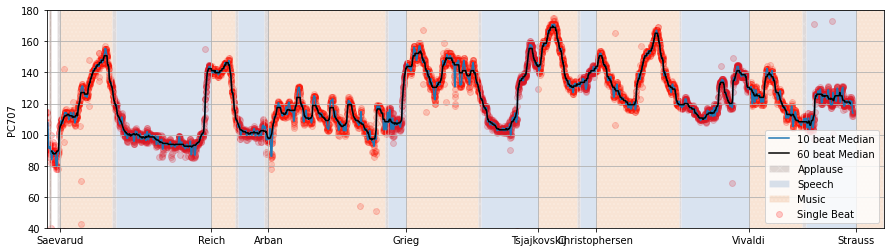

In [229]:
event_times = C_times[concert]
event_types = C_times['Event_Type']
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
df_sig = pd.DataFrame(index = time_s)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'10 beat Median'] = f(time_s)
df_sig.plot(ax = ax1)

HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'60bMed'] = f(time_s)
df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 beat Median')

time_start =  event_times[0]-5
event_types = event_types
ax1.margins(0)
for ev in event_palette.keys():
    ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
ax1.legend()

for i in range(len(event_times)-1):
    et = event_types[i]
    if et in event_palette.keys():
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
ax1.set_ylim(bpm_range)
ax1.set_ylabel(p)

M_times = C_times.loc[C_times['Event_Type']=='Music',:]

ax1.set_xticks(M_times[concert])
ax1.set_xticklabels(M_times['Event'])
ax1.grid()

plt.show()

BR604


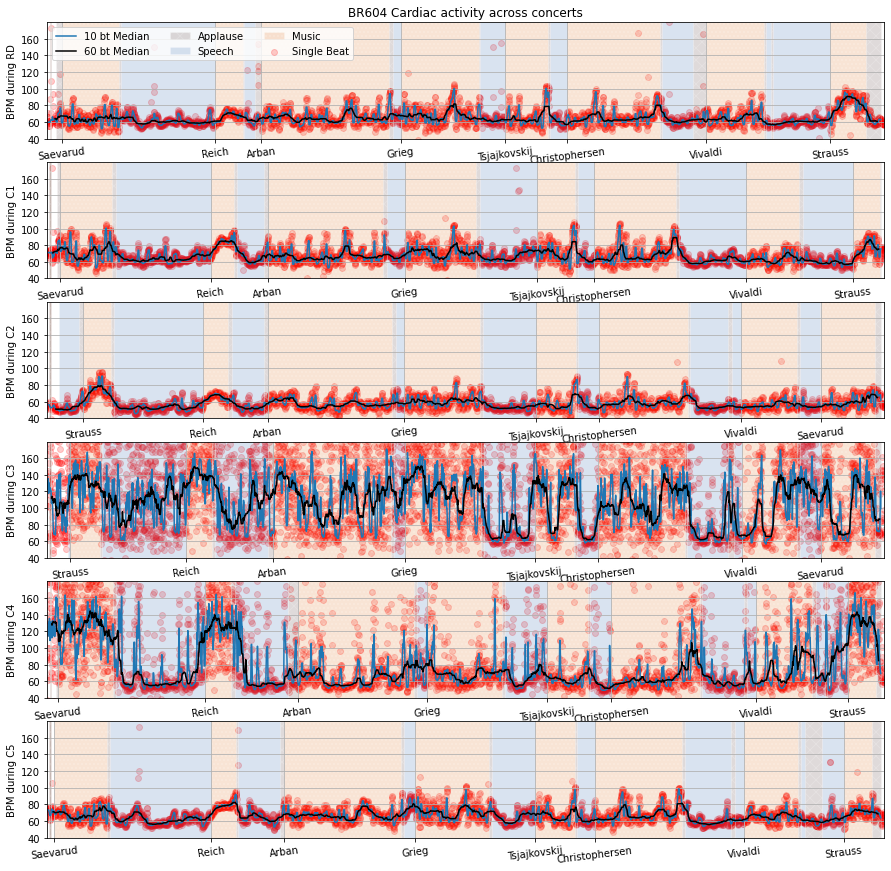

In [219]:
datafile_type = 'CIBI'
bpm_range = [40,180]
partID =  PartIDs[partN]
print(partID)

fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

for j in range(len(concerts)):
    concert = concerts[j]

    C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
    C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
    M_times = C_times.loc[C_times['Event_Type']=='Music',:]
    event_times = C_times[concert]
    event_types = C_times['Event_Type']
    
    s_time = -15 #C_times.loc[0,concert]
    e_time = C_times[concert].iloc[-1]
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
    
    data_loc = concert_loc[concert] + piece + '/'
    sig_files = sig_folders[concert].copy() 
    if partID in sig_files.keys():
        V = pd.read_csv(sig_files[partID])

        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = V['c_sTime']
        sig_v = V['Interbeat Interval (MS)']

        df_sig = pd.DataFrame(index = time_s)
        ax1 = ax[j]
        ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

        HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

        HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
        f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        

        
        time_start =  event_times[0]-5
        event_types = event_types
        ax1.margins(0)
        for ev in event_palette.keys():
            ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
        if j == 0:
            #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
            ax1.legend(ncol=3)

        for i in range(len(event_times)-1):
            et = event_types[i]
            if et in event_palette.keys():
                ei= event_times.iloc[i]
                ej = event_times.iloc[i+1]
                ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
        
        ax1.set_ylim(bpm_range)
        ax1.set_yticks([40,60,80,100,120,140,160])
        ax1.set_xticks(M_times[concert])
        ax1.set_xticklabels(M_times['Event'],rotation = 7)
        ax1.grid()
        ax1.set_ylabel('BPM during ' + concert)
        
ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))

plt.savefig('_'.join(['../Coordination/plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)

plt.show()

In [205]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
bpm_range = [40,180]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]
            ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

            HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'10 bt Median'] = f(time_s)
            df_sig['10 bt Median'].plot(ax = ax1,label = '10 bt Median')

            HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
            f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')


            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(bpm_range)
            ax1.set_yticks([40,60,80,100,120,140,160])
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('BPM during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['../Coordination/plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


BR601
BR602
BR603
BR604
BR605
BR606
BR607
LS401
LS402
LS403
LS404
LS405
LS406
LS407
LS408
LS410
PC701
PC702
PC703
PC704
PC705
PC706
PC707
PC708
VA301
VA302
VA303
VA304
VA305
VA306
VA307
VA308
VN101
VN102
VN103
VN104
VN105
VN106
VN107
VN108
VN201
VN202
VN203
VN204
VN205
VN206
VN207
VN208
VN209
VN210
WW501
WW502
WW503
WW504
WW505
WW506
WW507


# Assess HRV
Consider options for getting local HRV measurements

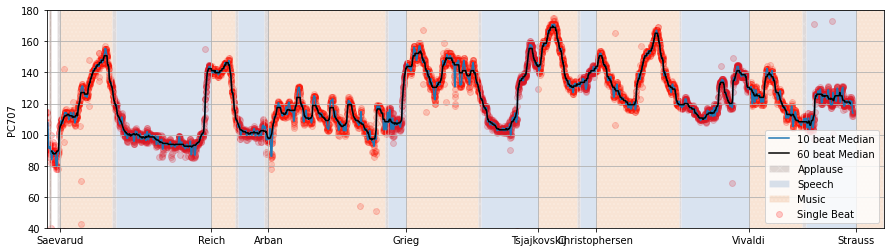

In [247]:
event_times = C_times[concert]
event_types = C_times['Event_Type']
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

V = pd.read_csv(sig_files[p])
sig_t = V['c_sTime']
sig_v = V['Interbeat Interval (MS)']
df_sig = pd.DataFrame(index = time_s)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
ax1.scatter(x =sig_t,y=(60000/sig_v),color='r',alpha = 0.2,label='Single Beat')

HR = (60000/sig_v).rolling(10,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'10 beat Median'] = f(time_s)
df_sig.plot(ax = ax1)

HR = (60000/sig_v).rolling(60,center=True).median() # really lazy smoothing
f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
df_sig.loc[:,'60bMed'] = f(time_s)
df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 beat Median')

time_start =  event_times[0]-5
event_types = event_types
ax1.margins(0)
for ev in event_palette.keys():
    ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
ax1.legend()

for i in range(len(event_times)-1):
    et = event_types[i]
    if et in event_palette.keys():
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
ax1.set_ylim(bpm_range)
ax1.set_ylabel(p)

M_times = C_times.loc[C_times['Event_Type']=='Music',:]

ax1.set_xticks(M_times[concert])
ax1.set_xticklabels(M_times['Event'])
ax1.grid()

plt.show()

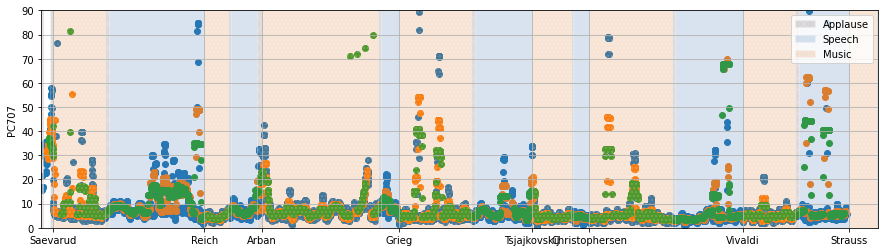

In [248]:
# ms difference style
# Root mean square of successive RR interval differences
# yeah this gets a big boost at big changes in rate.
roll_c = 10
a = sig_v.diff().pow(2).rolling(roll_c,center=True).mean().pow(0.5)

fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
ax1.scatter(x = sig_t, y = a)
roll_c = 30
a = sig_v.diff().pow(2).rolling(roll_c,center=True).mean().pow(0.5)
ax1.scatter(x = sig_t, y = a)
roll_c = 60
a = sig_v.diff().pow(2).rolling(roll_c,center=True).mean().pow(0.5)
ax1.scatter(x = sig_t, y = a)

time_start =  event_times[0]-5
event_types = event_types
ax1.margins(0)
for ev in event_palette.keys():
    ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
ax1.legend()

for i in range(len(event_times)-1):
    et = event_types[i]
    if et in event_palette.keys():
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
ax1.set_ylim([0,90])
ax1.set_ylabel(p)

M_times = C_times.loc[C_times['Event_Type']=='Music',:]
ax1.set_xticks(M_times[concert])
ax1.set_xticklabels(M_times['Event'])
ax1.grid()
plt.show()

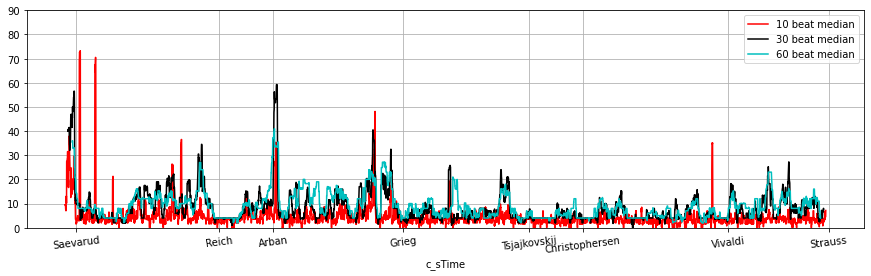

In [250]:
# quartile on milliseconds
# bit boost at big changes in heart rate

roll_c = 10
b = (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.75)- (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t


fig, (ax) = plt.subplots(1, 1,figsize = [15,4])
roll_c = 10
b = (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.75)- (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t
b.plot(color = 'r',label=str(roll_c) + ' beat median',ax = ax)
roll_c = 30
b = (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.75)- (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t
b.plot(color = 'k',label=str(roll_c) + ' beat median',ax = ax)
roll_c = 60
b = (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.75)- (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t
b.plot(color = 'c',label=str(roll_c) + ' beat median',ax = ax)


ax.set_ylim([0,90])
ax.set_xticks(M_times[concert])
ax.set_xticklabels(M_times['Event'],rotation = 7)
plt.legend()
plt.grid()
plt.show()

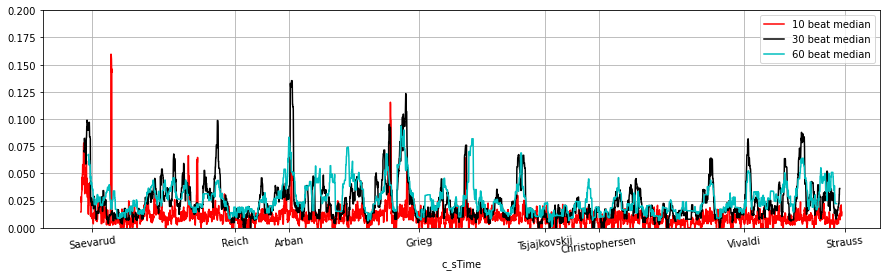

In [258]:
# quartile ratio 
# this gets overwhelmed by transitions in heart rate. Misleading

fig, (ax) = plt.subplots(1, 1,figsize = [15,4])
roll_c = 10
a = pd.Series(np.divide(sig_v,sig_v.rolling(roll_c,center=True).median()))
b = a.rolling(roll_c,center=True).quantile(0.75)-a.rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t
b.plot(color = 'r',label=str(roll_c) + ' beat median',ax = ax)

roll_c = 30
a = pd.Series(np.divide(sig_v,sig_v.rolling(roll_c,center=True).median()))
b = a.rolling(roll_c,center=True).quantile(0.75)-a.rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t
b.plot(color = 'k',label=str(roll_c) + ' beat median',ax = ax)

roll_c = 60
a = pd.Series(np.divide(sig_v,sig_v.rolling(roll_c,center=True).median()))
b = a.rolling(roll_c,center=True).quantile(0.75)-a.rolling(roll_c,center=True).quantile(0.25)
b.index = sig_t
b.plot(color = 'c',label=str(roll_c) + ' beat median',ax = ax)

ax.set_ylim([0,0.2])
ax.set_xticks(M_times[concert])
ax.set_xticklabels(M_times['Event'],rotation = 7)
plt.legend()
plt.grid()
plt.show()

Is there a meter of HRV that isn't just capturing big swings in stable heart rate? 

The measures against local medians unfortunately amplify these transitions. Hence larger differences on wider intervals in rolling quartiles. 

On the other hand, using median on successive difference really flattens out a lot of putential 

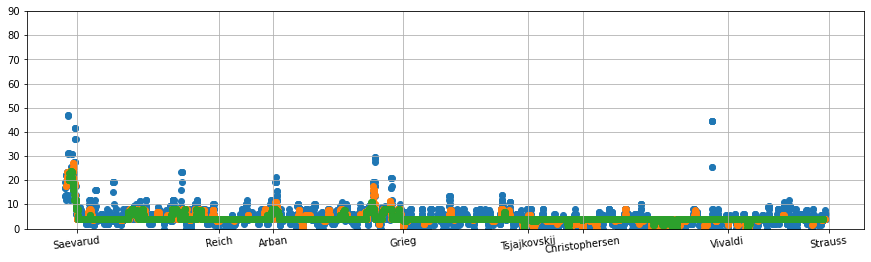

In [240]:
# ms difference style
# quartile ms? 

a = sig_v.diff().abs().rolling(10,center=True).median() 

fig, (ax) = plt.subplots(1, 1,figsize = [15,4])
ax.scatter(x = sig_t, y = a)
a = sig_v.diff().abs().rolling(30,center=True).median() 
ax.scatter(x = sig_t, y = a)
a = sig_v.diff().abs().rolling(60,center=True).median() 
ax.scatter(x = sig_t, y = a)
ax.set_xticks(M_times[concert])
ax.set_xticklabels(M_times['Event'],rotation = 7)
ax.set_ylim([0,90])
plt.grid()
plt.show()

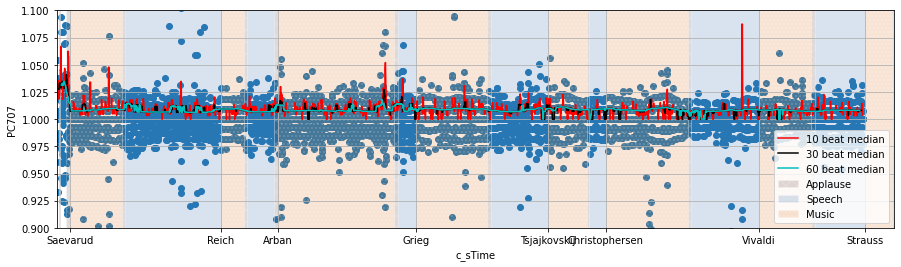

In [239]:
# ratio difference style 
a = sig_v.copy()
division = pd.Series(np.divide(a.values[1:],a.values[:-1]))
a.loc[1:] = division
a.iloc[0]=1
a.iloc[-1]=1
b = (a-1).abs().rolling(10,center=True).median()+1
b.index = sig_t


fig, (ax1) = plt.subplots(1, 1,figsize = [15,4])
ax1.scatter(x = sig_t, y = a)
b.plot(color = 'r',label='10 beat median',ax = ax1)

b = (a-1).abs().rolling(30,center=True).median()+1
b.index = sig_t
b.plot(color = 'k',label='30 beat median',ax = ax1)


b = (a-1).abs().rolling(60,center=True).median()+1
b.index = sig_t
b.plot(color = 'c',label='60 beat median',ax = ax1)

time_start =  event_times[0]-5
event_types = event_types
ax1.margins(0)
for ev in event_palette.keys():
    ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
ax1.legend()

for i in range(len(event_times)-1):
    et = event_types[i]
    if et in event_palette.keys():
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
ax1.set_ylim([0.9,1.1])
ax1.set_ylabel(p)

M_times = C_times.loc[C_times['Event_Type']=='Music',:]

ax1.set_xticks(M_times[concert])
ax1.set_xticklabels(M_times['Event'])
ax1.grid()
plt.show()

Trying to identify which of the local HRV measures might be most useful. 

ratio difference and ms difference medians seem to show substantial changes in character over time, with some spots standing out to a similar degree in both metrics. 

Median interval makes a difference for noise and scale of quality caught. 10 is very sensitive to abnormal/noisy beat times. 30 seems workable, representing 15-30 seconds, 60 might be easiest for interpretation over large intervals of time. 

* Lets see if ratio difference is better for comparison between people and performances than ms. 


In [196]:
partN = 3

PC707


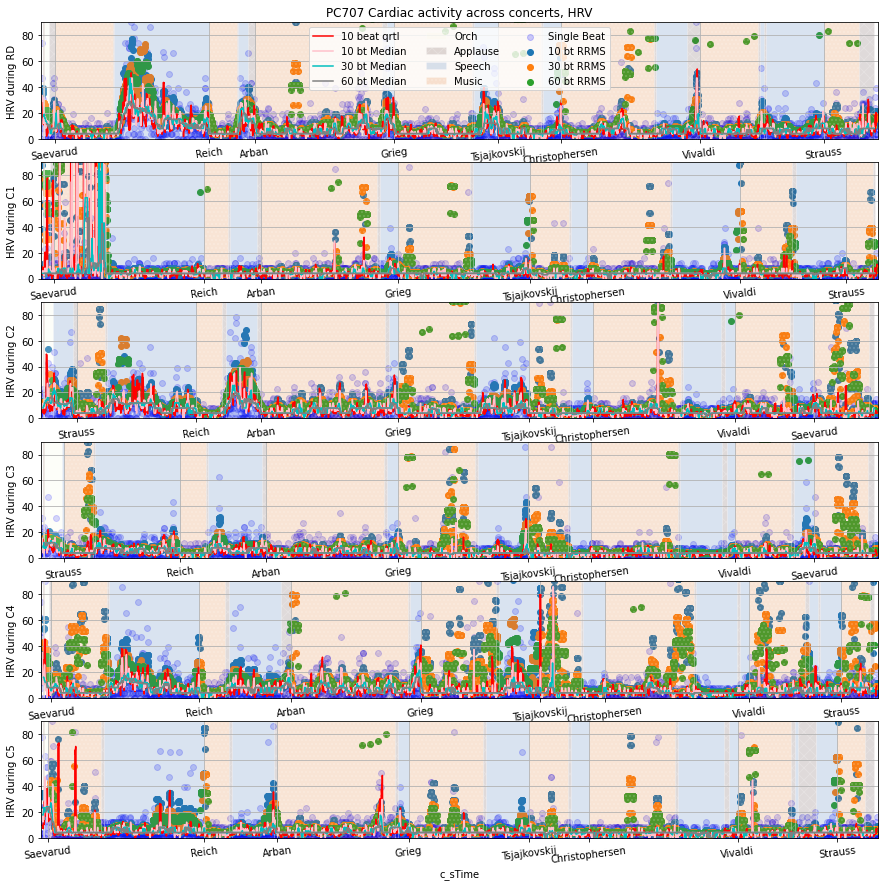

In [267]:
# by ms
datafile_type = 'CIBI'
HRV_range = [0,90]
partID =  PartIDs[partN]
print(partID)

fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

for j in range(len(concerts)):
    concert = concerts[j]

    C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
    C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
    M_times = C_times.loc[C_times['Event_Type']=='Music',:]
    event_times = C_times[concert]
    event_types = C_times['Event_Type']
    
    s_time = -15 #C_times.loc[0,concert]
    e_time = C_times[concert].iloc[-1]
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
    
    data_loc = concert_loc[concert] + piece + '/'
    sig_files = sig_folders[concert].copy() 
    if partID in sig_files.keys():
        V = pd.read_csv(sig_files[partID])

        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = V['c_sTime']
        sig_v = V['Interbeat Interval (MS)']
        
        
        df_sig = pd.DataFrame(index = time_s)
        ax1 = ax[j]
        
        a = sig_v.diff().abs().rolling(10,center=True).median() 
        a = sig_v.diff()
        ax1.scatter(x =sig_t,y=(a),color='b',alpha = 0.2,label='Single Beat')
        
        roll_c = 10
        b = (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.75)- (sig_v - sig_v.rolling(roll_c,center=True).median()).abs().rolling(roll_c,center=True).quantile(0.25)
        b.index = sig_t
        b.plot(color = 'r',label=str(roll_c) + ' beat qrtl',ax = ax1)

        roll_c = 10
        a = sig_v.diff().pow(2).rolling(roll_c,center=True).mean().pow(0.5)
        ax1.scatter(x = sig_t, y = a,label='10 bt RRMS')
        roll_c = 30
        a = sig_v.diff().pow(2).rolling(roll_c,center=True).mean().pow(0.5)
        ax1.scatter(x = sig_t, y = a,label='30 bt RRMS')
        roll_c = 60
        a = sig_v.diff().pow(2).rolling(roll_c,center=True).mean().pow(0.5)
        ax1.scatter(x = sig_t, y = a,label='60 bt RRMS')
        

        HRV = sig_v.diff().abs().rolling(10,center=True).median() 
        f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,color = 'pink',label = '10 bt Median')

        HRV = sig_v.diff().abs().rolling(30,center=True).median()  # really lazy smoothing
        f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
        df_sig.loc[:,'30bMed'] = f(time_s)
        df_sig['30bMed'].plot(color = 'c',ax = ax1,label = '30 bt Median')
        
        HRV = sig_v.diff().abs().rolling(60,center=True).median()  # really lazy smoothing
        f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'grey',ax = ax1,label = '60 bt Median')
        
        
        time_start =  event_times[0]-5
        event_types = event_types
        ax1.margins(0)
        for ev in event_palette.keys():
            ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
        if j == 0:
            #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
            ax1.legend(ncol=3)

        for i in range(len(event_times)-1):
            et = event_types[i]
            if et in event_palette.keys():
                ei= event_times.iloc[i]
                ej = event_times.iloc[i+1]
                ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
        
        ax1.set_ylim(HRV_range)
#         ax1.set_yticks([40,60,80,100,120,140,160])
        ax1.set_xticks(M_times[concert])
        ax1.set_xticklabels(M_times['Event'],rotation = 7)
        ax1.grid()
        ax1.set_ylabel('HRV during ' + concert)
        
ax[0].set_title(' '.join([partID,'Cardiac activity across concerts, HRV']))

#plt.savefig('_'.join(['../Coordination/plots/BPM/Cardiac',partID,piece,'BPM.jpg']),bbox_inches = 'tight',dpi = 200)

plt.show()

BR604


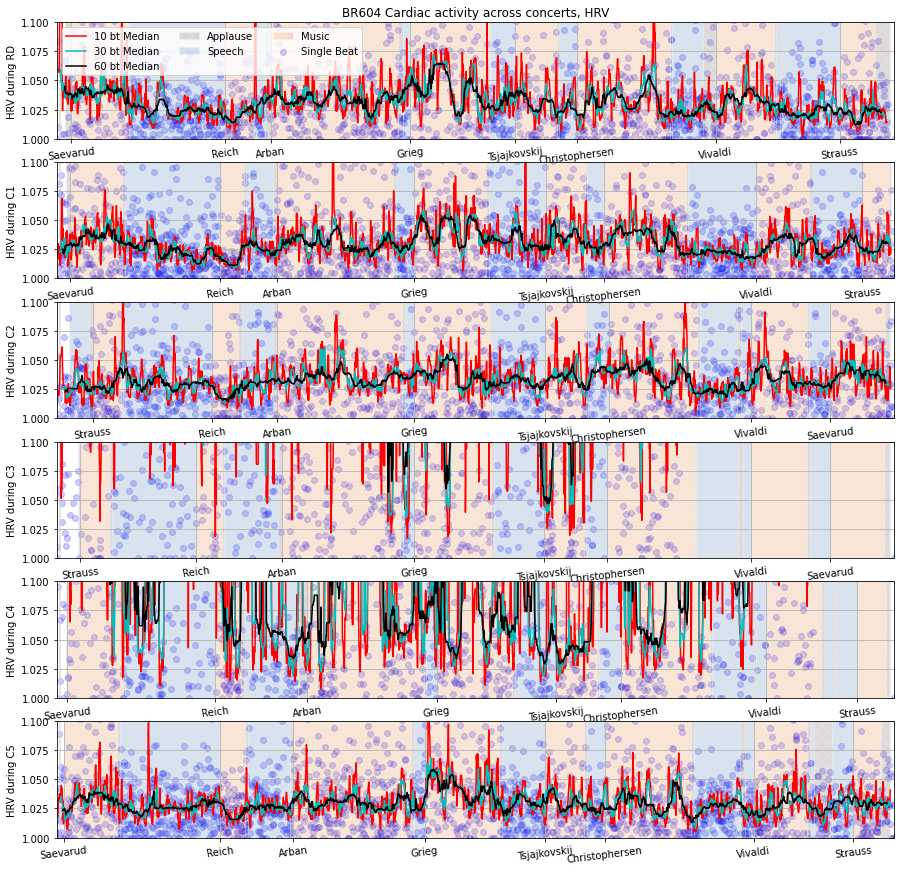

In [198]:
# by ratio
datafile_type = 'CIBI'
HRV_range = [1,1.1]
partID =  PartIDs[partN]
print(partID)

fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

for j in range(len(concerts)):
    concert = concerts[j]

    C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
    C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
    M_times = C_times.loc[C_times['Event_Type']=='Music',:]
    event_times = C_times[concert]
    event_types = C_times['Event_Type']
    
    s_time = -15 #C_times.loc[0,concert]
    e_time = C_times[concert].iloc[-1]
    dur = e_time - s_time
    time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
    
    data_loc = concert_loc[concert] + piece + '/'
    sig_files = sig_folders[concert].copy() 
    if partID in sig_files.keys():
        V = pd.read_csv(sig_files[partID])

        # cut extreme outliers
        V = V.loc[V['Interbeat Interval (MS)']>330,:]
        sig_t = V['c_sTime']
        sig_v = V['Interbeat Interval (MS)']

        df_sig = pd.DataFrame(index = time_s)
        ax1 = ax[j]
        
        a = sig_v.copy()
        division = pd.Series(np.divide(a.values[1:],a.values[:-1]))
        a.loc[1:] = division
        a.loc[0]=1
        a.iloc[-1]=1
        ax1.scatter(x =sig_t,y=(a),color='b',alpha = 0.2,label='Single Beat')

        b = (a-1).abs().rolling(10,center=True).median()+1
        b.index = sig_t
        HRV = b
        f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
        df_sig.loc[:,'10 bt Median'] = f(time_s)
        df_sig['10 bt Median'].plot(ax = ax1,color = 'r',label = '10 bt Median')

        b = (a-1).abs().rolling(30,center=True).median()+1
        b.index = sig_t
        HRV = b # really lazy smoothing
        f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
        df_sig.loc[:,'30bMed'] = f(time_s)
        df_sig['30bMed'].plot(color = 'c',ax = ax1,label = '30 bt Median')
        
        b = (a-1).abs().rolling(60,center=True).median()+1
        b.index = sig_t 
        HRV = b # really lazy smoothing
        f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
        df_sig.loc[:,'60bMed'] = f(time_s)
        df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')
        
        
        time_start =  event_times[0]-5
        event_types = event_types
        ax1.margins(0)
        for ev in event_palette.keys():
            ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
        if j == 0:
            #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
            ax1.legend(ncol=3)

        for i in range(len(event_times)-1):
            et = event_types[i]
            if et in event_palette.keys():
                ei= event_times.iloc[i]
                ej = event_times.iloc[i+1]
                ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)
        
        ax1.set_ylim(HRV_range)
#         ax1.set_yticks([40,60,80,100,120,140,160])
        ax1.set_xticks(M_times[concert])
        ax1.set_xticklabels(M_times['Event'],rotation = 7)
        ax1.grid()
        ax1.set_ylabel('HRV during ' + concert)
        
ax[0].set_title(' '.join([partID,'Cardiac activity across concerts, HRV']))

# plt.savefig('_'.join(['../Coordination/plots/HRV/Cardiac',partID,piece,'HRV1.jpg']),bbox_inches = 'tight',dpi = 200)

plt.show()

In [195]:
# ammount of material missing from Movensense recordings
np.array([0,0.7,0.7,0.2,0.7,0.2,0.8,0.5,0,1,1,0]).mean()

0.48333333333333334

In [208]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
HRV_range = [0,90]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]

            a = sig_v.diff()
            ax1.scatter(x =sig_t,y=(a),color='b',alpha = 0.2,label='Single Beat')

            HRV = sig_v.diff().abs().rolling(10,center=True).median() 
            f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
            df_sig.loc[:,'10 bt Median'] = f(time_s)
            df_sig['10 bt Median'].plot(ax = ax1,color = 'r',label = '10 bt Median')

            HRV = sig_v.diff().abs().rolling(30,center=True).median()  # really lazy smoothing
            f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
            df_sig.loc[:,'30bMed'] = f(time_s)
            df_sig['30bMed'].plot(color = 'c',ax = ax1,label = '30 bt Median')

            HRV = sig_v.diff().abs().rolling(60,center=True).median()  # really lazy smoothing
            f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')

            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(HRV_range)
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('HRV (ms) during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['../Coordination/plots/HRV/Cardiac',partID,piece,'HRV1.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


BR601
BR602
BR603
BR604
BR605
BR606
BR607
LS401
LS402
LS403
LS404
LS405
LS406
LS407
LS408
LS410
PC701
PC702
PC703
PC704
PC705
PC706
PC707
PC708
VA301
VA302
VA303
VA304
VA305
VA306
VA307
VA308
VN101
VN102
VN103
VN104
VN105
VN106
VN107
VN108
VN201
VN202
VN203
VN204
VN205
VN206
VN207
VN208
VN209
VN210
WW501
WW502
WW503
WW504
WW505
WW506
WW507


In [264]:
datafile_type = 'EQCIBI'
piece = 'Full'
sigName = 'CIBI'
HRV_range = [1,1.1]
for partID in PartIDs:
    print(partID)

    fig, (ax) = plt.subplots(len(concerts), 1,figsize = [15,15])

    for j in range(len(concerts)):
        concert = concerts[j]

        C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
        C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
        M_times = C_times.loc[C_times['Event_Type']=='Music',:]
        event_times = C_times[concert]
        event_types = C_times['Event_Type']

        s_time = -15 #C_times.loc[0,concert]
        e_time = C_times[concert].iloc[-1]
        dur = e_time - s_time
        time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

        data_loc = concert_loc[concert] + piece + '/'
        sig_files = sig_folders[concert].copy() 
        if partID in sig_files.keys():
            V = pd.read_csv(sig_files[partID])

            # cut extreme outliers
            V = V.loc[V['Interbeat Interval (MS)']>330,:]
            sig_t = V['c_sTime']
            sig_v = V['Interbeat Interval (MS)']

            df_sig = pd.DataFrame(index = time_s)
            ax1 = ax[j]

            a = sig_v.copy()
            division = pd.Series(np.divide(a.values[1:],a.values[:-1]))
            a.loc[1:] = division
            a.iloc[0]=1
            a.iloc[-1]=1
            ax1.scatter(x =sig_t,y=a ,color='b',alpha = 0.2,label='Single Beat')

            b = (a-1).abs().rolling(10,center=True).median()+1
            b.index = sig_t
            HRV = b
            f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
            df_sig.loc[:,'10bt Median'] = f(time_s)
            df_sig['10bt Median'].plot(ax = ax1,color = 'r',label = '10 bt Median')

            b = (a-1).abs().rolling(30,center=True).median()+1
            b.index = sig_t
            HRV = b # really lazy smoothing
            f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
            df_sig.loc[:,'30bMed'] = f(time_s)
            df_sig['30bMed'].plot(color = 'c',ax = ax1,label = '30 bt Median')

            b = (a-1).abs().rolling(60,center=True).median()+1
            b.index = sig_t 
            HRV = b # really lazy smoothing
            f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
            df_sig.loc[:,'60bMed'] = f(time_s)
            df_sig['60bMed'].plot(color = 'k',ax = ax1,label = '60 bt Median')

            time_start =  event_times[0]-5
            event_types = event_types
            ax1.margins(0)
            for ev in event_palette.keys():
                ax1.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",alpha = 0.2)
            if j == 0:
                #ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
                ax1.legend(ncol=3)

            for i in range(len(event_times)-1):
                et = event_types[i]
                if et in event_palette.keys():
                    ei= event_times.iloc[i]
                    ej = event_times.iloc[i+1]
                    ax1.axvspan(ei,ej, facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",alpha = 0.2)

            ax1.set_ylim(HRV_range )
            ax1.set_xticks(M_times[concert])
            ax1.set_xticklabels(M_times['Event'],rotation = 7)
            ax1.grid()
            ax1.set_ylabel('HRV ratio during ' + concert)

    ax[0].set_title(' '.join([partID,'Cardiac activity across concerts']))
    plt.savefig('_'.join(['../Coordination/plots/HRV2/Cardiac',partID,piece,'HRV2.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()


BR601
BR602
BR603
BR604
BR605
BR606
BR607
LS401
LS402
LS403
LS404
LS405
LS406
LS407
LS408
LS410
PC701
PC702
PC703
PC704
PC705
PC706
PC707
PC708
VA301
VA302
VA303
VA304
VA305
VA306
VA307
VA308
VN101
VN102
VN103
VN104
VN105
VN106
VN107
VN108
VN201
VN202
VN203
VN204
VN205
VN206
VN207
VN208
VN209
VN210
WW501
WW502
WW503
WW504
WW505
WW506
WW507


In [175]:
pwd

'/Users/finn/Desktop/Current_Projects/Stavanger/Signal_Preparation'

# gather Local HR values from IBI

From these definitions of HRV and HR, can we make plots per concert of these values against each other for each performer? 

25 bt medians? 


In [99]:
concert = 'RD'

sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 10 
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

parts = ['VN1','VN2','VA3','LS4','WW5','BR6','PC7']
player_order = pd.Series(data = Players_Card[concert])
# player_order_stretched = ['']
k = 0
sectN = []
for p in parts:
    sectN.append(k)
    sect = list(player_order[player_order.str.startswith(p)])
    k += len(sect)

yticks = sectN
yticklabels =['Violin 1','Violin 2','Viola','Cello/Bass','Woodwinds','Brass','Misc/Perc']

In [100]:
# local heart rate estimate
sf = 1
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
df_sig = pd.DataFrame(index = time_s,columns = Players_Card[concert],dtype='float')
df_sig2 = df_sig.copy()
roll_count = 25

for partID in Players_Card[concert]: #sig_files.keys(): # player_order: #Players_Resp[concert]: to be corrected for this signal
    V = pd.read_csv(sig_files[partID])
    V = V.loc[V['Interbeat Interval (MS)']>330,:]
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    HR = (60000/sig_v).rolling(roll_count,center=True).median() # really lazy smoothing
    f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
    df_sig.loc[:,partID] = f(time_s)
    
    a = sig_v.copy()
    division = pd.Series(np.divide(a.values[1:],a.values[:-1]))
    a.loc[1:] = division
    a.iloc[0]=1
    a.iloc[-1]=1
    b = (a-1).abs().rolling(roll_count,center=True).median()+1
    b.index = sig_t 
    HRV = b
    f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
    df_sig2.loc[:,partID] = f(time_s)
    
# Adjust for heart rate differences
df_scaledSig = df_sig.copy()
for c in df_sig.columns:
    df_scaledSig[c] = df_scaledSig[c]/df_sig[c].median()

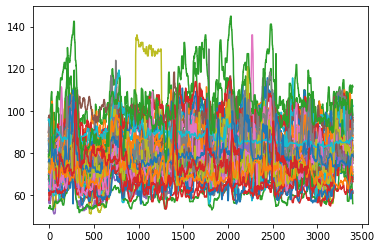

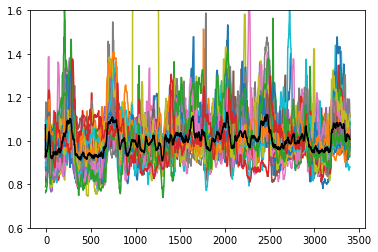

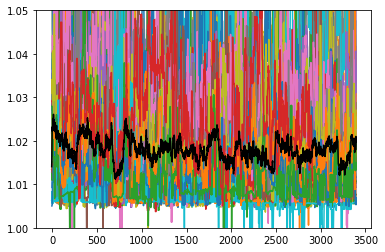

0        1
0  1.00000 -0.62812
1 -0.62812  1.00000

In [101]:
df_sig.plot(legend = False)
plt.show()
df_scaledSig.plot(legend = False)
df_scaledSig.median(axis=1).plot(color = 'k',legend = False)
plt.ylim([0.6,1.6])
plt.show()
df_sig2.plot(legend = False)
df_sig2.median(axis=1).plot(color = 'k',legend = False)
plt.ylim([0,90])
plt.ylim([1,1.05])
plt.show()
pd.concat([df_scaledSig.median(axis=1),df_sig2.median(axis=1)],axis=1).corr()

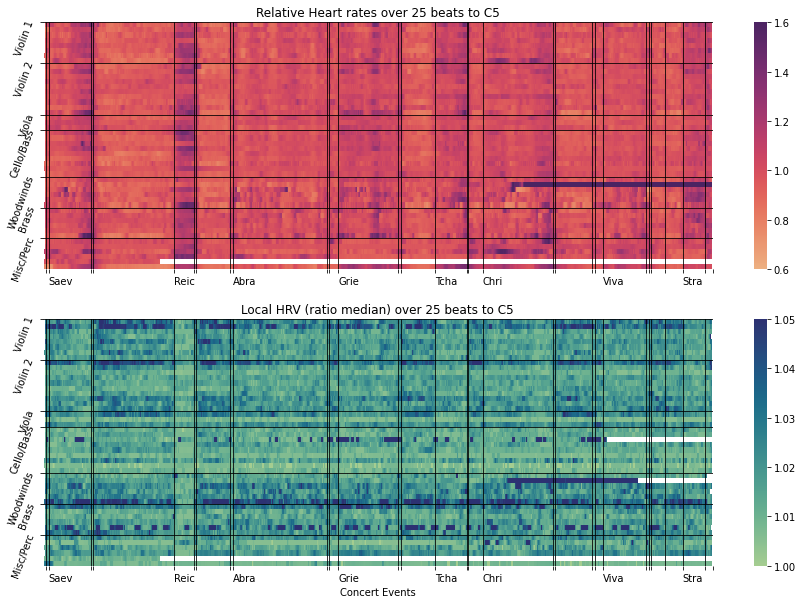

In [541]:
fig, (axs) = plt.subplots(2, 1,figsize = [15,10])
ax = axs[0]
times = df_scaledSig.index
xticks = (len(times)*(C_times[concert]-times[0])/(times[-1]-times[0])).astype('int')
xticklabels = C_times['Xticklabels'] 

chart = sns.heatmap(data=df_scaledSig.transpose(),vmin=0.6, vmax=1.6,cmap="flare", ax=ax) #
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,ha = 'left',rotation = 0)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation = 70)
ax.set_title('Relative Heart rates over ' +str(roll_count)+ ' beats to ' + concert)
ax.grid(color='k')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
# plt.show()

ax = axs[1]
times = df_sig2.index
xticks = (len(times)*(C_times[concert]-times[0])/(times[-1]-times[0])).astype('int')
xticklabels = C_times['Xticklabels'] 

chart = sns.heatmap(data=df_sig2.transpose(),vmin=1, vmax=1.05, ax=ax,cmap="crest")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,ha = 'left',rotation = 0)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation = 70)
ax.set_title('Local HRV (ratio median) over ' +str(roll_count)+ ' beats to ' + concert)
ax.set_xlabel('Concert Events')
ax.grid(color='k')
plt.savefig('./plots/Cardio_relHR_HRV_over' +str(roll_count)+'bt_'+concert+'.png',dpi = 300)
plt.show()

In [612]:
concert = 'C1'
sig_files = sig_folders[concert].copy()
player_order = pd.Series(data = Players_Card[concert])

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]
C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']

piece = 'Full'
sf = 4
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

df_sig = pd.DataFrame(index = time_s,columns = player_order,dtype='float')
df_sig2 = df_sig.copy()
roll_count = 25*sf

for partID in player_order: #sig_files.keys(): # player_order: #Players_Resp[concert]: to be corrected for this signal
    V = pd.read_csv(sig_files[partID])
    V = V.loc[V['Interbeat Interval (MS)']>330,:]
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    HR = (60000/sig_v).rolling(roll_count,center=True).median() # really lazy smoothing
    f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
    df_sig.loc[:,partID] = f(time_s)
    
    # HRV RMSSD https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/
    HRV = sig_v.diff().pow(2).rolling(roll_count,center=True).mean().pow(0.5)
    f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
    df_sig2.loc[:,partID] = f(time_s)
    
k = 0
sectN = []
for p in ['VN1','VN2','VA3','LS4','WW5','BR6','PC7']:
    sectN.append(k)
    sect = list(player_order[player_order.str.startswith(p)])
    k += len(sect)
yticks = sectN
yticklabels =['Violin 1','Violin 2','Viola','Cello/Bass','Woodwinds','Brass','Misc/Perc']

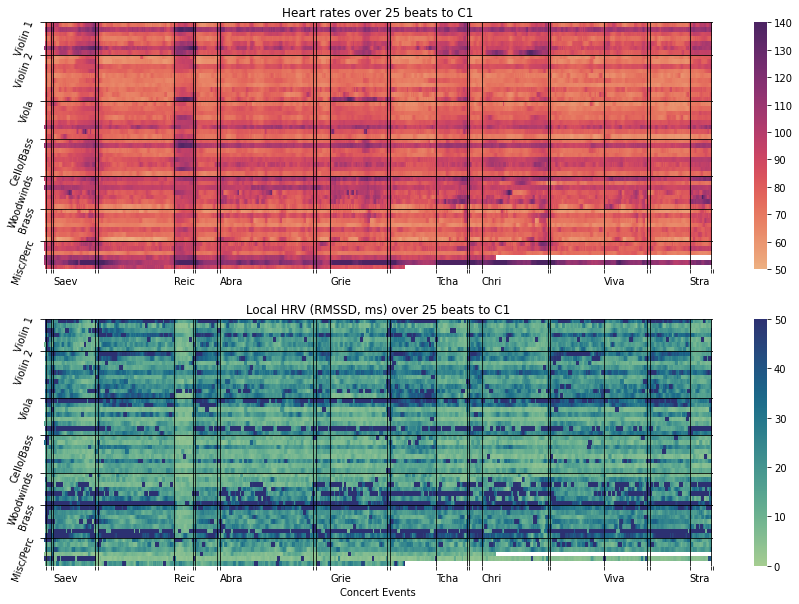

In [613]:
fig, (axs) = plt.subplots(2, 1,figsize = [15,10])
ax = axs[0]
times = df_sig.index
xticks = (len(times)*(C_times[concert]-times[0])/(times[-1]-times[0])).astype('int')
xticklabels = C_times['Xticklabels'] 

chart = sns.heatmap(data=df_sig.transpose(),vmin=50, vmax=140,cmap="flare", ax=ax) #
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,ha = 'left',rotation = 0)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation = 70)
ax.set_title('Heart rates over ' +str(roll_count)+ ' beats to ' + concert)
ax.grid(color='k')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
# plt.show()

ax = axs[1]
times = df_sig2.index
xticks = (len(times)*(C_times[concert]-times[0])/(times[-1]-times[0])).astype('int')
xticklabels = C_times['Xticklabels'] 

chart = sns.heatmap(data=df_sig2.transpose(),vmin=0, vmax=50, ax=ax,cmap="crest")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,ha = 'left',rotation = 0)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation = 70)
ax.set_title('Local HRV (RMSSD, ms) over ' +str(roll_count)+ ' beats to ' + concert)
ax.set_xlabel('Concert Events')
ax.grid(color='k')
plt.savefig('./plots/Cardio_HR_HRV_over' +str(roll_count)+'bt_'+concert+'.png',dpi = 300)
plt.show()

Event Event_Type Related        C5
0                    Synch Taps       Orch    Init     0.000
1                      Saevarud      Music    Saev    15.336
2         Applause for Saevarud   Applause    Saev   246.166
3                  MC pre Reich     Speech    Reic   257.826
4                         Reich      Music    Reic   694.972
5            Applause for Reich   Applause    Reic   802.967
6                  MC pre Arban     Speech    Arba   813.700
7          Applause for Florian   Applause    Arba   997.015
8                         Arban      Music    Abra  1012.486
9            Applause for Arban   Applause    Abra  1520.986
10                 MC pre Grieg     Speech    Grie  1533.898
11                        Grieg      Music    Grie  1581.658
12           Applause for Grieg   Applause    Grie  1904.608
13          MC pre Tsjajkovskij     Speech    Tcha  1917.820
14                 Tsjajkovskij      Music    Tcha  2102.386
15    Applause for Tsjajkovskij   Applause    Tcha  2273.980
16        MC pre Christophersen     Speech    Chri  2284.684
17               Christophersen      Music    Chri  2362.576
18  Applause for Christophersen   Applause    Chri  2739.538
19                MC pre School     Speech    Viva  2751.286
20    Applause for school class   Applause    Viva  2950.744
21               MC pre Vivaldi     Speech    Viva  2970.154
22                      Vivaldi      Music    Viva  3008.884
23         Applause for Vivaldi   Applause    Viva  3242.818
24              MC post Vivaldi     Speech    Viva  3258.274
25    Applause for school class   Applause    Viva  3273.124
26               MC pre Strauss     Speech    Stra  3348.316
27                      Strauss      Music    Stra  3441.964
28         Applause for Strauss   Applause    Stra  3564.004
29                          End      Stage    Last  3602.818

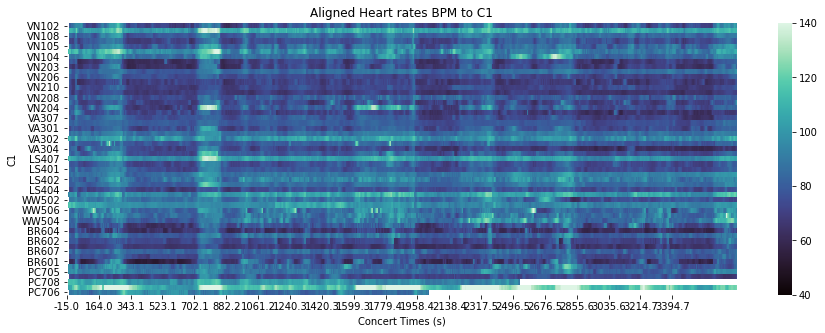

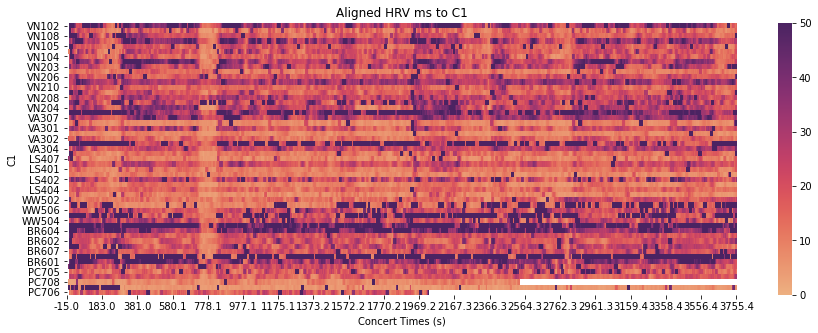

In [616]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,5])

#df_sig = df_scaledSig.loc[60:180,:].diff().copy()
times = df_scaledSig.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig.transpose(),vmin=40, vmax=140,cmap="mako", ax=ax) #
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned Heart rates BPM to ' + concert)

ax.set_xlabel('Concert Times (s)')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

fig, (ax) = plt.subplots(1, 1,figsize =[15,5])

times = df_sig2.index
num_ticks = 20
xticks = np.linspace(0, len(times) - 1, num_ticks, dtype='int')
xticklabels = [np.round(times[idx],1) for idx in xticks]

chart = sns.heatmap(data=df_sig2.transpose(),vmin=0, vmax=50, ax=ax,cmap="flare")
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,rotation = 0)
ax.set_ylabel(concert)
ax.set_title('Aligned HRV ms to ' + concert)

ax.set_xlabel('Concert Times (s)')
#plt.savefig('./plots/2_performances_'+ piece_name+ '_set_'+sigName+'.png',dpi = 300)
plt.show()

In [287]:
def backplot(concert_event_times,concert_event_types,event_palette,y_range,ax = ax):
    # function to add type-wise background colours to plots based on information in concert_times
    event_times = concert_event_times
    time_start =  event_times[0]-5
    event_types = concert_event_types
    ax.margins(0)
    for ev in event_palette.keys():
        ax.axvspan(time_start,time_start+5,0,1, facecolor=event_palette[ev],label=ev,hatch = event_hatching[ev],edgecolor="w",)
    ax.legend()#fontsize = 8)

    for i in range(len(event_times)-1):
        et = event_types[i]
        ei= event_times.iloc[i]
        ej = event_times.iloc[i+1]
        ax.axvspan(ei,ej,y_range[0],y_range[1], facecolor=event_palette[et],label=et,hatch = event_hatching[et],edgecolor="w",)
    return

# Plot data

In [69]:
concert = 'C3'

sig_files = sig_folders[concert].copy()   

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]

piece = 'Full'
sf = 3
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']
# C_times

# parts = ['VN1','VN2','VA3','LS4','WW5','BR6','PC7']
player_order = pd.Series(data = Players_Card[concert])
# local heart rate estimate
sf = 1
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)
df_sig = pd.DataFrame(index = time_s,columns = Players_Card[concert],dtype='float')
df_sig2 = df_sig.copy()
roll_count = 20

for partID in Players_Card[concert]: #sig_files.keys(): # player_order: #Players_Resp[concert]: to be corrected for this signal
    V = pd.read_csv(sig_files[partID])
    V = V.loc[V['Interbeat Interval (MS)']>330,:]
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    HR = (60000/sig_v).rolling(roll_count,center=True).median() # really lazy smoothing
    f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
    df_sig.loc[:,partID] = f(time_s)
    
    # HRV RMSSD https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/
    HRV = sig_v.diff().pow(2).rolling(roll_count,center=True).mean().pow(0.5)
    f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
    df_sig2.loc[:,partID] = f(time_s)
    

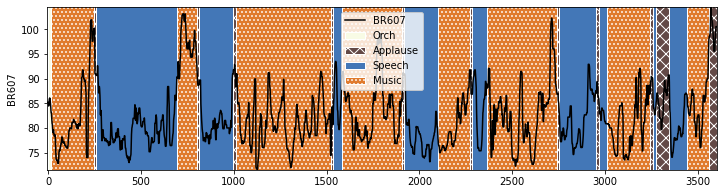

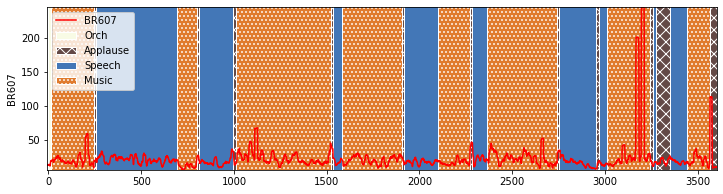

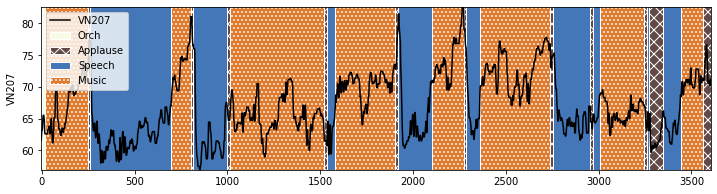

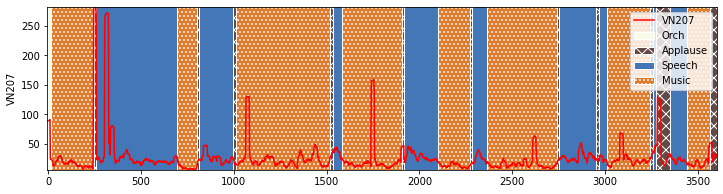

In [664]:
event_times = C_times[concert]
event_types = C_times['Event_Type']
event_palette = {'Orch':(0.972,0.984,0.8980),'Applause':(0.388,0.286,0.275),'Speech':(0.263,0.467,0.718),'Music':(0.878,0.482,0.180)}
event_hatching = {'Orch':'', 'Applause':'xx', 'Speech':'', 'Music':'...'}
y_range = [0,1024]

parts = df_sig.columns
for p in ['BR607','VN207']:
    fig, (ax) = plt.subplots(1, 1,figsize = [12,3])
    df_sig[p].plot(color='k',ax = ax)
    ax.set_ylabel(p)
    backplot(event_times,event_types,event_palette,y_range,ax = ax)
    plt.show()
    fig, (ax) = plt.subplots(1, 1,figsize = [12,3])
    df_sig2[p].plot(color='r',ax = ax)
    ax.set_ylabel(p)
    backplot(event_times,event_types,event_palette,y_range,ax = ax)
    plt.show()

Start with LS403, isolating intervals of presumably quiet breathing and active respiration.

Text(0.5, 1.0, 'C5 Reich heart rate by VN207')

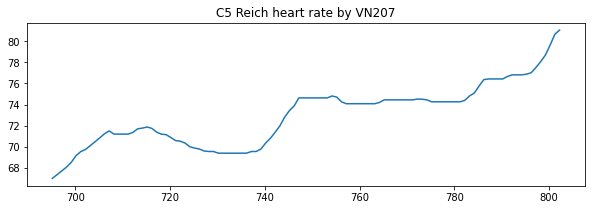

In [665]:
ev_n = 4
p = 'VN207'
df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p].plot(figsize = (10,3))
plt.title(concert + ' ' + C_times.loc[ev_n,'Event'] + ' heart rate by ' + p)

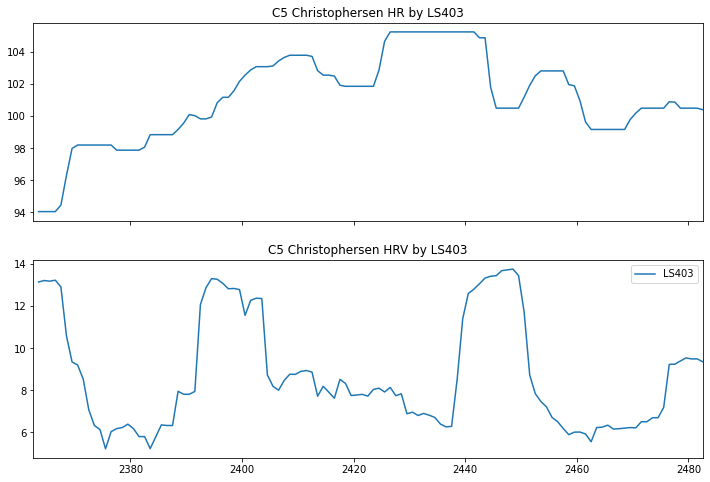

In [666]:
p = 'LS403'
ev_n = 17
sample_dur = 120
sig = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n,concert]+sample_dur,p]

fig, axs = plt.subplots(2,1, sharex='all',figsize=(12,8))
ax = axs[0]
sig.plot(ax=ax)
plt.xlim(C_times.loc[ev_n,concert],C_times.loc[ev_n+1,concert]) 
ax.set_title(concert + ' ' + C_times.loc[ev_n,'Event'] + ' HR by ' + p)

ax = axs[1]
sig = df_sig2.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n,concert]+sample_dur,p]
sig.plot(ax=ax)
plt.xlim(C_times.loc[ev_n,concert],C_times.loc[ev_n+1,concert]) 
ax.set_title(concert + ' ' + C_times.loc[ev_n,'Event'] + ' HRV by ' + p)

plt.legend()
plt.xlim(C_times.loc[ev_n,concert],C_times.loc[ev_n,concert]+sample_dur) 
# plt.savefig('_'.join(['phase_components',p,concert,str(ev_n),'.png']),dpi = 300)
plt.show()

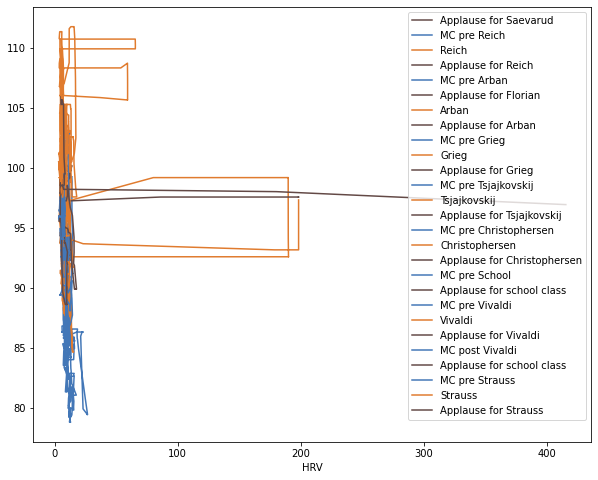

In [667]:
#Breaths.iloc[-10:,:]
fig, (ax) = plt.subplots(1, 1,figsize = [10,8])
for ev_n in range(2,len(C_times)-1):
    secs = pd.DataFrame()
    secs['HR'] = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
    secs['HRV'] = df_sig2.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
    secs.plot(x = 'HRV', y = 'HR',label= C_times.loc[ev_n,'Event'],color = event_palette[C_times.loc[ev_n,'Event_Type']], ax = ax)
plt.legend()

# plt.xlim([1,1.07])
# plt.ylim([50,160])
plt.show()

First try normalising by quiet breathing, taking the median depth of the median length inspiration, which for wind players who breath more rarely during active play, will be from the times between. 

OR I could consider only the time between...

Median for not playing time? 

In [33]:
p = 'VN102'
# p = 'LS403'
for p in player_order:
    fig, ax = plt.subplots(1, 2,figsize = [10,4])
    thr = 0.05
    HR_bin = np.linspace(df_sig[p].quantile(thr),df_sig[p].quantile(1-thr),25,endpoint=True)
    HRV_bin = np.linspace(df_sig2[p].quantile(thr),np.min([df_sig2[p].quantile(1-thr),50]),25,endpoint=True)
    S_sigs = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        if C_times.loc[ev_n,'Event_Type']=='Speech':
            secs = pd.DataFrame()
            secs['HR'] = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            secs['HRV'] = df_sig2.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            S_sigs = pd.concat([S_sigs,secs],axis=0)
    counts, xedges, yedges, im = ax[0].hist2d(S_sigs.HRV,S_sigs.HR, bins=(HRV_bin,HR_bin), vmin = 0, vmax = 20,cmap='inferno')
    cbar = fig.colorbar(im, ax=ax[0])
    cbar.set_ticks([])
    ax[0].set_title('During MC Speechs, '+concert+' ' + p)
    ax[0].set_xlabel('HRV, ms')
    ax[0].set_ylabel('HR, BPM')

    M_sigs = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        if C_times.loc[ev_n,'Event_Type']=='Music':
            secs = pd.DataFrame()
            secs['HR'] = df_sig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            secs['HRV'] = df_sig2.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            M_sigs = pd.concat([M_sigs,secs],axis=0)
    counts, xedges, yedges, im = ax[1].hist2d(M_sigs.HRV,M_sigs.HR, bins=(HRV_bin,HR_bin), vmin = 0, vmax = 20, cmap='inferno')
    cbar = fig.colorbar(im, ax=ax[1])
    cbar.set_ticks([])
    ax[1].set_title('During Music, '+concert+' ' + p)
    ax[1].set_xlabel('HRV, ms')
    ax[1].set_ylabel('HR, BPM')
    plt.savefig('_'.join(['./plots/Card_params/Cardiac',p,concert,'_BPM_dist.jpg']),bbox_inches = 'tight',dpi = 200)
#     plt.show()
    plt.close()

In [579]:
HR_bin = np.linspace(0.5,1.5,25,endpoint=True)
HRV_bin = np.linspace(1,1.05,25,endpoint=True)

KeyError: 'VN202'

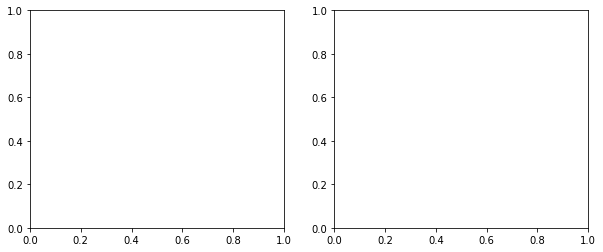

In [658]:
# p = 'VN203'
#p = 'LS403'
for p in player_order:
    fig, ax = plt.subplots(1, 2,figsize = [10,4])

    S_sigs = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        if C_times.loc[ev_n,'Event_Type']=='Speech':
            secs = pd.DataFrame()
            secs['HR'] = df_scaledSig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            secs['HRV'] = df_sig2.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            S_sigs = pd.concat([S_sigs,secs],axis=0)
    counts, xedges, yedges, im = ax[0].hist2d(S_sigs.HRV,S_sigs.HR, bins=(HRV_bin,HR_bin), cmap='inferno')
    fig.colorbar(im, ax=ax[0])
    ax[0].set_title('Listening to Speech cardiac ' + p)
    ax[0].set_xlabel('HRV, ratio')
    ax[0].set_ylabel('Relative HR')

    M_sigs = pd.DataFrame()
    for ev_n in range(2,len(C_times)-1):
        if C_times.loc[ev_n,'Event_Type']=='Music':
            secs = pd.DataFrame()
            secs['HR'] = df_scaledSig.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            secs['HRV'] = df_sig2.loc[C_times.loc[ev_n,concert]:C_times.loc[ev_n+1,concert],p]
            M_sigs = pd.concat([M_sigs,secs],axis=0)
    counts, xedges, yedges, im = ax[1].hist2d(M_sigs.HRV,M_sigs.HR, bins=(HRV_bin,HR_bin), cmap='inferno')
    fig.colorbar(im, ax=ax[1])
    ax[1].set_title('Music playing cardiac ' + p)
    ax[1].set_xlabel('HRV, ratio')
    ax[1].set_ylabel('Relative HR')

    plt.savefig('_'.join(['./plots/Card_params/Cardiac_',concert,p,'_dist.jpg']),bbox_inches = 'tight',dpi = 200)
    plt.close()

In [531]:
# HR_bin = np.linspace(60,150,50,endpoint=True)
# HRV_bin = np.linspace(0,60,50,endpoint=True)

<AxesSubplot:xlabel='HRV', ylabel='HR'>

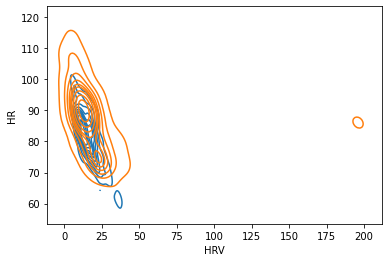

In [537]:
# https://www.python-graph-gallery.com/2d-density-plot/?utm_content=cmp-trueplt.hist2d(x, y, bins=(50, 50), cmap=plt.cm.jet)
#Breaths = respy.Breath_Features(df_sig.loc[C_times.loc[0,concert]:C_times.loc[29,concert],p],filtered=True)
#sns.kdeplot(x=Breaths.Insp_T, y=Breaths.Depth)
sns.kdeplot(x=S_sigs.HRV,y=S_sigs.HR)
sns.kdeplot(x=M_sigs.HRV,y=M_sigs.HR)

# Aligned local metrics out TODO

Local Relative rate, absolute rate, and HRV measures to be saved per cohort, at excessively high precision. 

In [224]:
concert = 'C5'
sig_files = sig_folders[concert].copy()
player_order = pd.Series(data = Players_Card[concert])

C_times = Piece_timings[['Event','Event_Type','Related',concert]].sort_values(concert)
C_times = C_times.loc[C_times[concert]>-15,:].reset_index(drop = True).copy()
M_times = C_times.loc[C_times['Event_Type']=='Music',:]
C_times['Xticklabels'] = ''
C_times.loc[C_times['Event_Type']=='Music','Xticklabels'] = C_times.loc[C_times['Event_Type']=='Music','Related']

piece = 'Full'
sf = 0.25
s_time = -15 #C_times.loc[0,concert]
e_time = C_times[concert].iloc[-1]
dur = e_time - s_time
time_s = s_time +  np.round(np.linspace(0,dur,int(sf*(dur)),endpoint=False),3)

df_HR = pd.DataFrame(index = time_s,columns = player_order,dtype='float')
df_HRV = df_HR.copy()
roll_count = int(12*sf)

for partID in player_order: #sig_files.keys(): # player_order: #Players_Resp[concert]: to be corrected for this signal
    V = pd.read_csv(sig_files[partID])
    V = V.loc[V['Interbeat Interval (MS)']>330,:]
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    
    sig_t = V['c_sTime']
    sig_v = V['Interbeat Interval (MS)']
    HR = (60000/sig_v).rolling(roll_count,center=True).median() # really lazy smoothing
    f = interpolate.interp1d(sig_t, HR,fill_value='extrapolate')
    df_HR.loc[:,partID] = f(time_s)
    
    # HRV RMSSD https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624990/
    HRV = sig_v.diff().pow(2).rolling(roll_count,center=True).mean().pow(0.5)
    f = interpolate.interp1d(sig_t, HRV,fill_value='extrapolate')
    df_HRV.loc[:,partID] = f(time_s)

# Adjust for heart rate differences
df_scaledSig = df_HR.copy()
for c in df_HR.columns:
    df_scaledSig[c] = df_scaledSig[c]/df_HR[c].median()


k = 0
sectN = []
for p in ['VN1','VN2','VA3','LS4','WW5','BR6','PC7']:
    sectN.append(k)
    sect = list(player_order[player_order.str.startswith(p)])
    k += len(sect)
yticks = sectN
yticklabels =['Violin 1','Violin 2','Viola','Cello/Bass','Woodwinds','Brass','Misc/Perc']

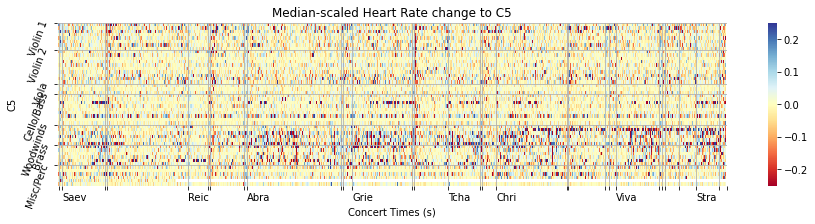

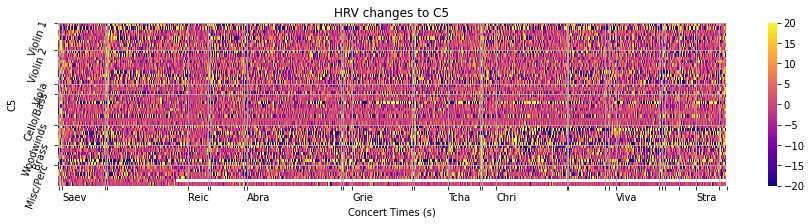

In [225]:
fig, (ax) = plt.subplots(1, 1,figsize = [15,3])

df_sig = df_scaledSig.diff().copy()
times = df_sig.index
xticks = (len(times)*(C_times[concert]-times[0])/(times[-1]-times[0])).astype('int')
xticklabels = C_times['Xticklabels'] 
sc=0.25
chart = sns.heatmap(data=df_sig.transpose(),vmin=-1*sc, vmax=1*sc, ax=ax,cmap='RdYlBu')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,ha = 'left',rotation = 0)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation = 70)
ax.set_ylabel(concert)
ax.set_title('Median-scaled Heart Rate change to ' + concert)
ax.set_xlabel('Concert Times (s)')
ax.grid()
plt.savefig('./plots/RelHR_change_'+concert+'.png',dpi = 200)
plt.show()

fig, (ax) = plt.subplots(1, 1,figsize = [15,3])
sc =20
df_sig = df_HRV.diff().copy()
chart = sns.heatmap(data=df_sig.transpose(),vmin=-1*sc, vmax=1*sc, ax=ax,cmap='plasma')
ax.set_xticks(xticks)
ax.set_xticklabels(xticklabels,ha = 'left',rotation = 0)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels,rotation = 70)
ax.set_ylabel(concert)
ax.set_title('HRV changes to ' + concert)
ax.set_xlabel('Concert Times (s)')
ax.grid()
plt.savefig('./plots/HRV_change_'+concert+'.png',dpi = 200)
plt.show()

In [226]:
df_HR.to_csv('../Data/Respiration/'+concert + '_Full_Scaled_HR.csv')
df_HRV.to_csv('../Data/Respiration/'+concert + '_Full_Scaled_HRV.csv')